# Quick Start Tutorial

GluonTS contains:

* A number of pre-built models
* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets

### Provided datasets

GluonTS comes with a number of publicly available datasets.

In [2]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again the next time around.

In [4]:
dataset = get_dataset("m4_hourly")

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/gluonts/dataset/common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


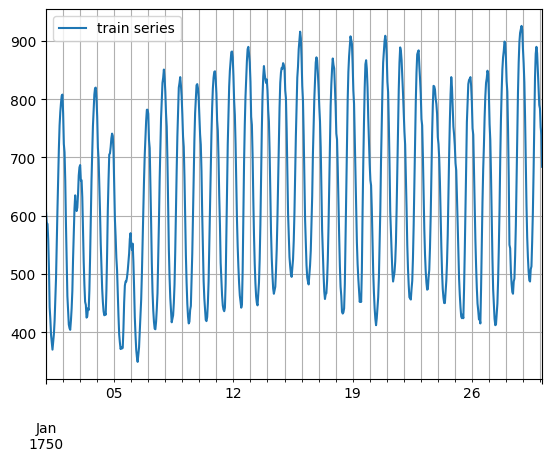

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

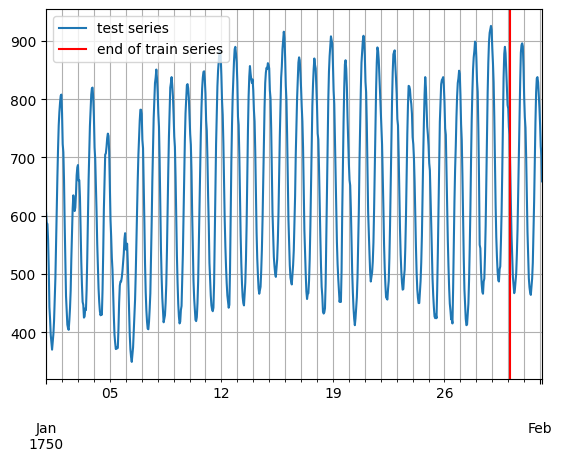

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [7]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Custom datasets

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Period` (possibly different for each time series):

In [8]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

/tmp/ipykernel_3977/2007592095.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series


Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

In [9]:
from gluonts.dataset.common import ListDataset

In [10]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GluonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of an `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [11]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [12]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [13]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 151.80it/s, epoch=1/5, avg_epoch_loss=5.64]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 150.09it/s, epoch=2/5, avg_epoch_loss=4.89]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 153.50it/s, epoch=3/5, avg_epoch_loss=4.73]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 152.73it/s, epoch=4/5, avg_epoch_loss=4.71]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 150.61it/s, epoch=5/5, avg_epoch_loss=4.83]

## Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [14]:
from gluonts.evaluation import make_evaluation_predictions

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [16]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [17]:
# first entry of the time series list
ts_entry = tss[0]

In [18]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [19]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [20]:
# first 5 values
dataset_test_entry["target"][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all this information by simply invoking the corresponding attribute of the forecast object.

In [21]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [22]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


We can also do calculations to summarize the sample paths, such as computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [23]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [656.8301  593.62317 507.7621  560.19147 533.6132  477.68454 475.19266
 521.62006 559.07806 607.34045 507.19827 617.89185 700.01794 812.90155
 863.4309  844.4272  766.49335 811.2046  819.93756 871.2954  777.4522
 842.5376  778.62775 759.9309  659.16516 535.54474 585.18896 425.0777
 511.04825 451.5377  471.60297 510.15735 512.3272  552.13367 589.8035
 733.70197 802.0394  818.2543  832.368   877.9747  965.2444  829.30585
 927.90326 875.8522  793.9871  756.0211  797.9769  690.6666 ]
0.5-quantile (median) of the future window:
 [672.58746 586.11975 519.2786  564.1543  515.0018  484.15073 492.16486
 528.90814 561.7334  601.94604 500.9475  613.4544  713.8728  819.8752
 862.93646 852.6691  800.42615 822.4439  823.6065  877.26666 798.9276
 822.2547  780.85736 749.40216 658.12726 547.11584 583.4626  439.69043
 525.48395 434.80704 470.32306 501.18228 503.32404 553.00684 581.06006
 724.60266 784.80896 820.8987  822.7163  900.4033  966.26355 843.14075
 925.8449  851.000

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

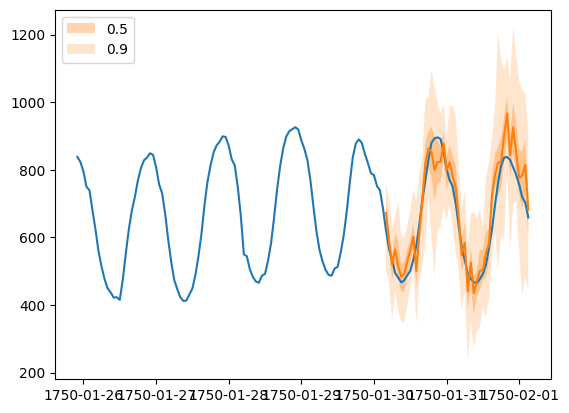

In [24]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [25]:
from gluonts.evaluation import Evaluator

In [26]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 414it [00:00, 11254.99it/s]

The aggregate metrics, `agg_metrics`, aggregate both across time-steps and across time series.

In [27]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 10353652.54473964,
    "abs_error": 10360954.195072174,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 3.9537099803003812,
    "MAPE": 0.2557887818346373,
    "sMAPE": 0.19288036810315173,
    "MSIS": 61.65597012019594,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 4983550.784189797,
    "Coverage[0.1]": 0.10451892109500804,
    "QuantileLoss[0.5]": 10360954.240943432,
    "Coverage[0.5]": 0.5307467793880837,
    "QuantileLoss[0.9]": 6920760.359059906,
    "Coverage[0.9]": 0.8778683574879227,
    "RMSE": 3217.7092076102276,
    "NRMSE": 0.43928837991973735,
    "ND": 0.07118051033685027,
    "wQuantileLoss[0.1]": 0.034237357045450105,
    "wQuantileLoss[0.5]": 0.07118051065198916,
    "wQuantileLoss[0.9]": 0.04754612799188189,
    "mean_absolute_QuantileLoss": 7421755.128064379,
    "mean_wQuantileLoss": 0.05098799856310706,
    "MAE_Coverage": 0.3926227858293075,
    

Individual metrics are aggregated only across time-steps.

In [28]:
item_metrics.head()

item_id    forecast_start            MSE     abs_error  abs_target_sum  \
0       0  1750-01-30 04:00    3388.305664   2193.886230         31644.0   
1       1  1750-01-30 04:00  174607.135417  18427.251953        124149.0   
2       2  1750-01-30 04:00   36602.427083   7121.232422         65030.0   
3       3  1750-01-30 04:00  223569.291667  18354.597656        235783.0   
4       4  1750-01-30 04:00  103810.302083  11672.973633        131088.0   

   abs_target_mean  seasonal_error      MASE      MAPE     sMAPE  \
0       659.250000       42.371302  1.078701  0.069746  0.067837   
1      2586.437500      165.107988  2.325151  0.156027  0.142711   
2      1354.791667       78.889053  1.880603  0.100835  0.107245   
3      4912.145833      258.982249  1.476501  0.079401  0.079289   
4      2731.000000      200.494083  1.212938  0.089112  0.084565   

   num_masked_target_values        ND       MSIS  QuantileLoss[0.1]  \
0                       0.0  0.069330  13.774889        1029.080524   
1                       0.0  0.148429  13.605702        4572.551636   
2                       0.0  0.109507  13.800707        3489.670313   
3                       0.0  0.077845  14.135824        9796.419873   
4                       0.0  0.089047  13.218125        5095.128149   

   Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.9]  \
0       0.020833        2193.886322       0.770833        1439.796960   
1       0.312500       18427.251831       0.979167        8531.256982   
2       0.000000        7121.232178       0.187500        2419.273828   
3       0.062500       18354.597656       0.375000        7536.722900   
4       0.062500       11672.973755       0.666667        7300.917358   

   Coverage[0.9]  
0       1.000000  
1       1.000000  
2       0.770833  
3       0.979167  
4       1.000000

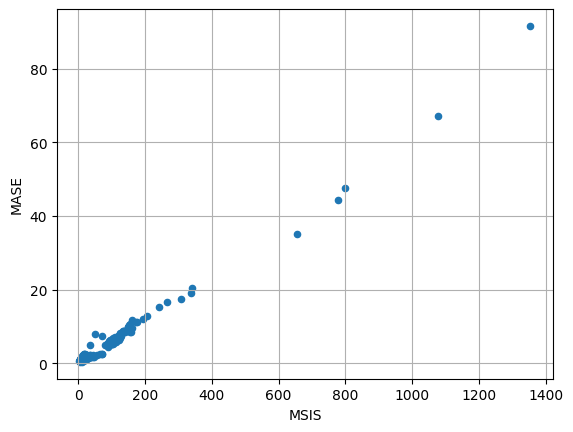

In [29]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()